In [286]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [287]:
df = pd.read_csv('owid-covid-data.csv', usecols=[2,3,4,5,7,8], engine='python').set_index('date').dropna()
df.head(5)

,location,total_cases,new_cases,total_deaths,new_deaths
date,,,,,
2020-03-23,Afghanistan,40.0,6.0,1.0,1.0
2020-03-24,Afghanistan,42.0,2.0,1.0,0.0
2020-03-25,Afghanistan,74.0,32.0,1.0,0.0
2020-03-26,Afghanistan,80.0,6.0,2.0,1.0
2020-03-27,Afghanistan,91.0,11.0,2.0,0.0


In [288]:
s = df.loc[df['location'].isin(['Thailand'])] #.dropna() #.set_index('date')
s

,location,total_cases,new_cases,total_deaths,new_deaths
date,,,,,
2020-03-01,Thailand,42.0,0.0,1.0,1.0
2020-03-02,Thailand,43.0,1.0,1.0,0.0
2020-03-03,Thailand,43.0,0.0,1.0,0.0
2020-03-04,Thailand,43.0,0.0,1.0,0.0
2020-03-05,Thailand,47.0,4.0,1.0,0.0
...,...,...,...,...,...
2022-03-09,Thailand,3111857.0,22984.0,23512.0,74.0
2022-03-10,Thailand,3136649.0,24792.0,23575.0,63.0
2022-03-11,Thailand,3161241.0,24592.0,23643.0,68.0


In [289]:
s.describe()

,total_cases,new_cases,total_deaths,new_deaths
count,7.400000e+02,740.000000,740.000000,740.000000
mean,6.304933e+05,4333.486486,5834.822973,32.135135
std,9.426590e+05,6604.036656,8739.612030,58.294856
min,4.200000e+01,0.000000,1.000000,0.000000
25%,3.426500e+03,7.000000,58.000000,0.000000
50%,2.640550e+04,246.500000,85.000000,1.000000
75%,1.342151e+06,7134.500000,13778.250000,37.000000
max,3.206955e+06,45714.000000,23778.000000,312.000000


##### ตรวจสอบค่า missing 

In [290]:
m = s[s.new_deaths == 0].reset_index()
m

,date,location,total_cases,new_cases,total_deaths,new_deaths
0,2020-03-02,Thailand,43.0,1.0,1.0,0.0
1,2020-03-03,Thailand,43.0,0.0,1.0,0.0
2,2020-03-04,Thailand,43.0,0.0,1.0,0.0
3,2020-03-05,Thailand,47.0,4.0,1.0,0.0
4,2020-03-06,Thailand,48.0,1.0,1.0,0.0
...,...,...,...,...,...,...
336,2021-04-13,Thailand,34575.0,965.0,97.0,0.0
337,2021-04-14,Thailand,35910.0,1335.0,97.0,0.0
338,2021-04-15,Thailand,37453.0,1543.0,97.0,0.0
339,2021-04-17,Thailand,40585.0,1547.0,100.0,0.0


##### ตรวจสอบ % ของค่า missing 

In [291]:
missing_zero = m.new_deaths[m.new_deaths == 0].count()
print('missing_zero = {}'.format(missing_zero))
print('{:.2f} %'.format(missing_zero / df.shape[0] * 100))

missing_zero = 341
0.23 %


##### การแปลงค่า missing ให้เป็นค่าเฉลี่ย 

In [292]:
#ในกรณีที่พบ 0 ไม่มาก คือไม่กี่ % ไม่ต้องตัดออกให้ใช้วิธีเติมค่าเฉลี่ย
s['NewCases'] = s.new_cases.replace(0, s.new_cases.mean())
s['NewDeaths'] = s.new_deaths.replace(0, s.new_deaths.mean())

dt = s.loc[:,['NewDeaths']].round(0)
dt 

C:\Users\Techatach\AppData\Local\Temp\ipykernel_18552\3292987917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['NewCases'] = s.new_cases.replace(0, s.new_cases.mean())
C:\Users\Techatach\AppData\Local\Temp\ipykernel_18552\3292987917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['NewDeaths'] = s.new_deaths.replace(0, s.new_deaths.mean())


,NewDeaths
date,
2020-03-01,1.0
2020-03-02,32.0
2020-03-03,32.0
2020-03-04,32.0
2020-03-05,32.0
...,...
2022-03-09,74.0
2022-03-10,63.0
2022-03-11,68.0


In [293]:
dt.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
NewDeaths,740.0,46.88,52.0,1.0,30.0,32.0,37.0,312.0


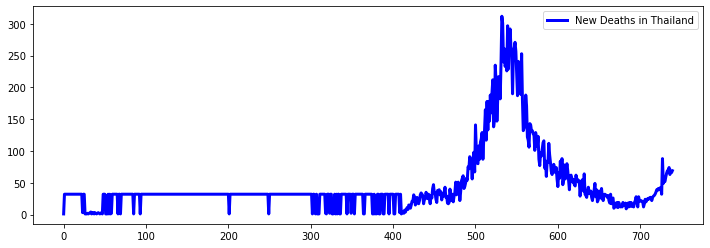

In [294]:

plt.figure(figsize=(12, 4))
plt.plot(dt.values, 'b', lw=3.0, label='New Deaths in Thailand')
plt.legend()
plt.show()

In [295]:
dt.info()
dt.shape

<class 'pandas.core.frame.DataFrame'>
Index: 740 entries, 2020-03-01 to 2022-03-13
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NewDeaths  740 non-null    float64
dtypes: float64(1)
memory usage: 11.6+ KB


(740, 1)

##### การแบ่งข้อมูลใช้ในการ train และ test

In [296]:
n_train = int(dt.shape[0] * 0.80)
n_train

592

##### การแปลงข้อมูลให้เป็น Normalize คือแปลงข้อมูลให้เป็นเลข 0-1

In [297]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
data_sc = sc.fit_transform(dt.values)
data_sc[:5]

array([[0.        ],
       [0.09967846],
       [0.09967846],
       [0.09967846],
       [0.09967846]])

##### สร้างฟังก์ชันเพื่อเตรียมข้อมูลให้เป็น matrix ใช้ step = 2

In [298]:
def convertToMatrix(data, step=2):
    X, Y, = [], []
    for i in range(len(data)-step):
        d = i + step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

##### การแบ่งข้อมูลเพื่อใช้ในการ train และ test 

In [299]:
train, test = data_sc[0:n_train], data_sc[n_train:]
train.shape, test.shape

((592, 1), (148, 1))

In [300]:
step = 2

X_train, y_train = convertToMatrix(train, step)
X_test, y_test = convertToMatrix(test, step)

print('Train Test (after conversion):', X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Train Test (after conversion): (590, 2, 1) (146, 2, 1)
(590, 1) (146, 1)


##### การสร้างโมเดล AI

In [301]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(step, 1), activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


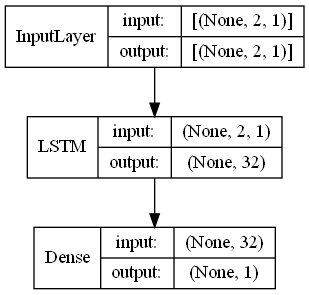

In [302]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'my_lstm.png', show_shapes=True, show_layer_names=False)

In [303]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [304]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
19/19 [==============================] - 1s 2ms/step - loss: 0.0464
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 3/50
19/19 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 9/50
19/19 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 11/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 12/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 13/50
19/19 [==============================

In [305]:
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

5/5 [==============================] - 0s 2ms/step - loss: 0.0011
0.0011006125714629889


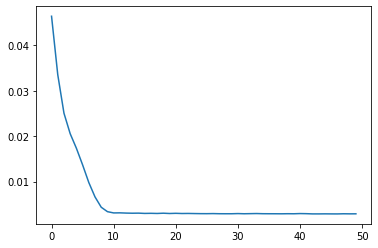

In [306]:
plt.plot(history.history['loss'], label='Train loss')
plt.legend
plt.show()

In [307]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict

array([[0.0460315 ],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.09287792],
       [0.05590285],
       [0.04900363],
       [0.09287792],
       [0.05338518],
       [0.00763099],
       [0.00763099],
       [0.00885416],
       [0.00908147],
       [0.00885416],
       [0.01153111],
       [0.01421299],
       [0.01198752],
       [0.01007837],
       [0.01298552],
       [0.01053367],
       [0.01007837],
       [0.01175907],
       [0.00908147],
       [0.00885416],
       [0.01153111],
       [0.01175907],
       [0.00908147],
       [0.00885416],
       [0.01153111],
       [0.01053367],
       [0.046

In [308]:
testPredict = model.predict(X_test)
test = np.argmax(testPredict, axis=1)

test2 = np.argmax(y_test, axis=1)

In [309]:
df = pd.DataFrame({'ข้อมูลจริง': test2, 'ข้อมูลพยากรณ์': test})
df 

,ข้อมูลจริง,ข้อมูลพยากรณ์
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
141,0,0
142,0,0
143,0,0
144,0,0


In [310]:
from sklearn.metrics import mean_squared_error, r2_score

trainPredict_inv = sc.inverse_transform(trainPredict)
testPredict_inv = sc.inverse_transform(testPredict)
y_train_inv = sc.inverse_transform(y_train)
y_test_inv = sc.inverse_transform(y_test)

r2_train = r2_score(y_train_inv, trainPredict_inv)
r2_test = r2_score(y_test_inv, testPredict_inv)

rmse_train = np.sqrt(mean_squared_error(y_train_inv, trainPredict_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, testPredict_inv))

print('R2_Train: {:.3f}'.format(r2_train))
print('R2_Test: {:.3f}'.format(r2_test))

print('RMSE Train: {:.3f}'.format(rmse_train))
print('RMSE Test: {:.3f}'.format(rmse_test))


R2_Train: 0.913
R2_Test: 0.738
RMSE Train: 16.809
RMSE Test: 10.318


In [311]:
prefix = np.empty(step).reshape(-1, 1)
prefix.fill(np.nan)

trainPredict_inv = np.concatenate((prefix, trainPredict_inv), axis=0)
testPredict_inv = np.concatenate((prefix, testPredict_inv), axis=0)

predict_inv = np.concatenate((trainPredict_inv, testPredict_inv), axis=0)


In [312]:
predict_inv

array([[         nan],
       [         nan],
       [ 15.31579781],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 29.88503075],
       [ 18.38578606],
       [ 16.24012947],
       [ 29.88503075],
       [ 17.60279083],
       [  3.37323761],
       [  3.37323761],
       [  3.75364447],
       [  3.82433772],
       [  3.75364327],
       [  4.58617544],
       [  5.4202404 ],
       [  4.72811842],
       [  4.13437462],
       [  5.03849554],
       [  4.27597189],
       [  4.13437462],
       [  4.65707016],
       [  3.82433772],
       [  3.75364447],
       [  4

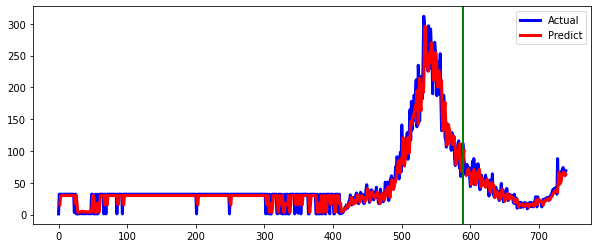

In [319]:
plt.figure(figsize=(10, 4))
plt.plot(dt.values, 'blue', lw=3.0, label='Actual')
plt.plot(predict_inv, 'r', lw=3.0, label='Predict')
plt.axvline(n_train-step-1, c='g', lw=2.0)
plt.legend()
plt.show()

##### นำส่วนท้ายมาเป็น input มาพยากรณ์จำนวนผู้ป่วยโควิด19 ในวันถัดไป 

In [320]:
X_input = X_train[-step]

pred = model.predict(X_input)
pred_inv = sc.inverse_transform(pred)

#มลพิษ ประเทศไทย ค่า PM 2.5 ไม่ควรเกิน 50 ไมโครกรัม ต่อลูกบาศก์เมตรใน 24 ชั่วโมง
print('พยากรณ์ผู้ป่วยโควิด19 ระยะเวลา 1 วัน (24 ชม.) =', pred_inv[-1][-1].round(0),'คน)')

พยากรณ์ผู้ป่วยโควิด19 ระยะเวลา 1 วัน (24 ชม.) = 55.0 คน)
